In [ ]:
import math
import numpy as np
import pandas as pd
import scipy
import  scipy.signal as sg

import requests
import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import mplfinance as mpf



In [7]:

def fetch_historical_data(base_curr, quote_curr, start_time, end_time, granularity=86400):
    """
    Fetches all available historical OHLCV data from Coinbase API.
    
    Args:
    - base_curr (str): Cryptocurrency base (e.g., "BTC", "ETH").
    - quote_curr (str): Cryptocurrency base (e.g., "USDT").
    - start_time (str): Start date in "YYYY-MM-DD" format.
    - end_time (str): End date in "YYYY-MM-DD" format.
    - granularity (int): Timeframe in seconds (default: 86400 for daily data).
    
    Returns:
    - pd.DataFrame: Dataframe containing all historical OHLCV data.
    """

    # Convert symbol format (BTCUSDT -> BTC-USD)
    pair = f"{base_curr}-{quote_curr}"

    url = f"https://api.exchange.coinbase.com/products/{pair}/candles"
    
    # Convert start_time and end_time to datetime objects
    start_dt = datetime.strptime(start_time, "%Y-%m-%d")
    end_dt = datetime.strptime(end_time, "%Y-%m-%d")

    all_data = []
    
    while start_dt < end_dt:
        batch_end = min(end_dt, start_dt + timedelta(seconds=granularity * 300))
        
        params = {
            "granularity": granularity,
            "start": start_dt.strftime("%Y-%m-%dT%H:%M:%SZ"),
            "end": batch_end.strftime("%Y-%m-%dT%H:%M:%SZ")
        }

        response = requests.get(url, params=params)
        
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break

        data = response.json()
        
        if not data:
            print("No data found for this period.")
            break
        
        all_data.extend(data)
        start_dt = batch_end + timedelta(seconds=granularity)

    if not all_data:
        print("No historical data available.")
        return None

    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=["timestamp", "low", "high", "open", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    df = df.sort_values("timestamp").reset_index(drop=True)

    return df

# Example Usage
df = fetch_historical_data("btc", "usdt", "2021-01-01", "2025-03-15")

In [8]:
df

,timestamp,low,high,open,close,volume
0,2021-05-04,53053.87,56617.70,55608.40,53053.87,253.462479
1,2021-05-05,52938.80,57933.11,53042.22,57486.84,269.341235
2,2021-05-06,55262.28,58361.40,57496.57,56409.60,468.837606
3,2021-05-07,55255.20,58649.79,56429.60,57330.60,456.679212
4,2021-05-08,56959.23,59492.81,57353.12,58865.94,348.770017
...,...,...,...,...,...,...
1407,2025-03-11,76568.32,83631.08,78654.26,82964.97,858.416433
1408,2025-03-12,80598.32,84466.04,82973.79,83682.95,650.069883
1409,2025-03-13,79924.93,84333.22,83695.27,81082.78,593.616611
1410,2025-03-14,80818.41,85302.25,81097.84,83981.73,318.176259


## Indicator

In [9]:
def sma(price, n):
  return price.rolling(n).mean()

### Simple Moving Averages Cross Over Signals

In [10]:
def sma_crossing_signals(df, short_window=20, long_window=60):
    df['SMA_20'] = sma(df['close'], short_window)
    df['SMA_60'] = sma(df['close'], long_window)

    df['Signal'] = np.where(df['SMA_20'] > df['SMA_60'], 1, -1)
    df['Crossover'] = df['Signal'].diff()

    return df

In [11]:
def backtest_trading_strategy(df, cash_to_invest=10000, 
                                initial_position=0,
                                transaction_cash_ratio=0.5,
                                transaction_cost=0.001):
    
    cash_on_hand_list = [cash_to_invest] * len(df)
    holdings = [0] * len(df)
    
    total_cash = cash_to_invest  
    for i in range(1, len(df)):
        
        if df.loc[df.index[i], 'Crossover'] == 2:
            invest_amount = total_cash * transaction_cash_ratio  
            position = invest_amount / df.loc[df.index[i], 'close'] / (1 + transaction_cost)  # Number of shares to buy
            
            total_cash -= invest_amount
            holdings[i] = position
            cash_on_hand_list[i] = total_cash
        
        elif df.loc[df.index[i], 'Crossover'] == -2:
            
            cash_return = holdings[i-1] * df.loc[df.index[i], 'close']
            total_cash += cash_return * (1 - transaction_cost)  
            
            holdings[i] = 0  
            cash_on_hand_list[i] = total_cash
        
        else:
            cash_on_hand_list[i] = total_cash
            holdings[i] = holdings[i-1]
    df['Cash'] = cash_on_hand_list
    df['Holdings'] = holdings
    df['Total_equity'] = df['Cash'] + df['Holdings']
    
    return df


In [13]:
def plot_chart(df):
    df = df.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(df.index, df['SMA_20'], label='SMA 20', color='blue', linestyle='--')
    ax.plot(df.index, df['SMA_60'], label='SMA 60', color='red', linestyle='--')

    buy_signals = df[df['Crossover'] == 2]  # Golden Cross
    sell_signals = df[df['Crossover'] == -2]  # Death Cross

    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal', alpha=1, edgecolor='black')
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal', alpha=1, edgecolor='black')

    ax.legend()
    ax.set_title("SMA Crossover Strategy")
    ax.set_ylabel("Price")
    plt.show()

    fig, ax2 = plt.subplots(figsize=(12, 6))
    ax2.plot(df.index, df['Total_equity'], label='Total Equity', color='green')
    ax2.set_ylabel("Total Equity ($)", color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim([min(df['Total_equity'].min(), df['Cash'].min()) - 1000, max(df['Total_equity'].max(), df['Cash'].max()) + 1000])

    
    
    ax3 = ax2.twinx()
    ax3.plot(df.index, df['Cash'], label='Cash On Hand', color='orange')
    ax3.set_ylabel("Cash On Hand", color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')

    plt.tight_layout()
    plt.title("Total Equity and Cash On Hand")
    plt.show()
    

    df_mpf = df[['open', 'high', 'low', 'close', 'volume']].copy()
    mpf.plot(df_mpf, type='candle', style='charles', 
             mav=(20, 60), volume=True, title="Candlestick with SMA", 
             figsize=(12, 6))
    

In [17]:
df = sma_crossing_signals(df)
df = backtest_trading_strategy(df)
print("The final equity is: ", df['Total_equity'].iloc[-1], "USD")
print("The total return is: ", (df['Total_equity'].iloc[-1] - 10000) / 10000 * 100, "%")

The final equity is:  15149.226111657716 USD
The total return is:  51.492261116577154 %


In [21]:
def plot_chart(df):
    df = df.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # Define the font properties
    title_font = {'family': 'serif', 'weight': 'bold', 'size': 16}

    # First plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['SMA_20'], label='SMA 20', color='blue', linestyle='--')
    ax.plot(df.index, df['SMA_60'], label='SMA 60', color='red', linestyle='--')

    buy_signals = df[df['Crossover'] == 2]  # Golden Cross
    sell_signals = df[df['Crossover'] == -2]  # Death Cross

    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal', alpha=1, edgecolor='black')
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal', alpha=1, edgecolor='black')

    ax.legend()
    ax.set_title("SMA Crossover Strategy", fontdict=title_font)
    ax.set_ylabel("Price")
    plt.show()

    # Second plot
    fig, ax2 = plt.subplots(figsize=(12, 6))
    ax2.plot(df.index, df['Total_equity'], label='Total Equity', color='green')
    ax2.set_ylabel("Total Equity ($)", color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim([min(df['Total_equity'].min(), df['Cash'].min()) - 1000, max(df['Total_equity'].max(), df['Cash'].max()) + 1000])

    ax3 = ax2.twinx()
    ax3.plot(df.index, df['Cash'], label='Cash On Hand', color='orange')
    ax3.set_ylabel("Cash On Hand", color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')

    plt.tight_layout()
    plt.title("Total Equity and Cash On Hand", fontdict=title_font)
    plt.show()

    # Third plot (Candlestick chart)
    df_mpf = df[['open', 'high', 'low', 'close', 'volume']].copy()
    mpf.plot(df_mpf, type='candle', style='charles', 
             mav=(20, 60), volume=True, title="Candlestick with SMA", 
             figsize=(12, 6))


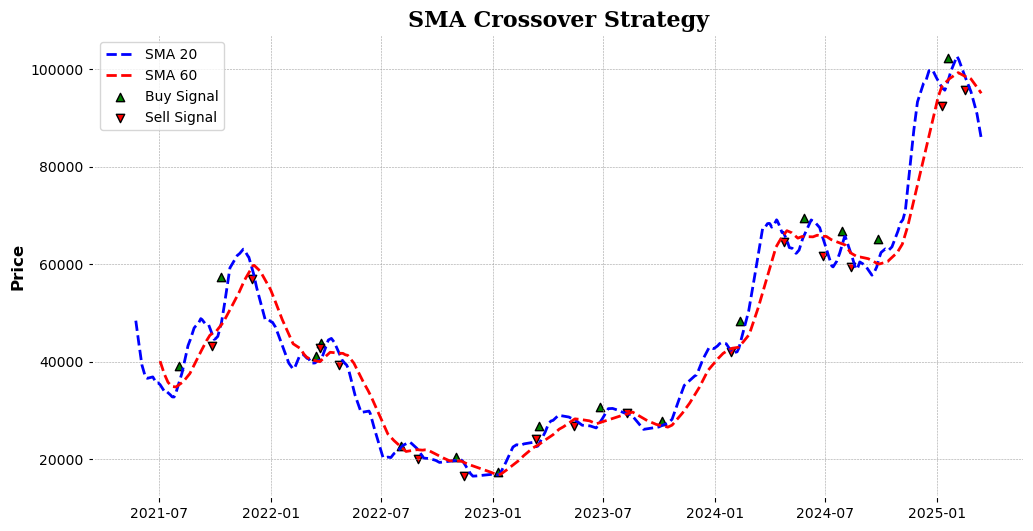

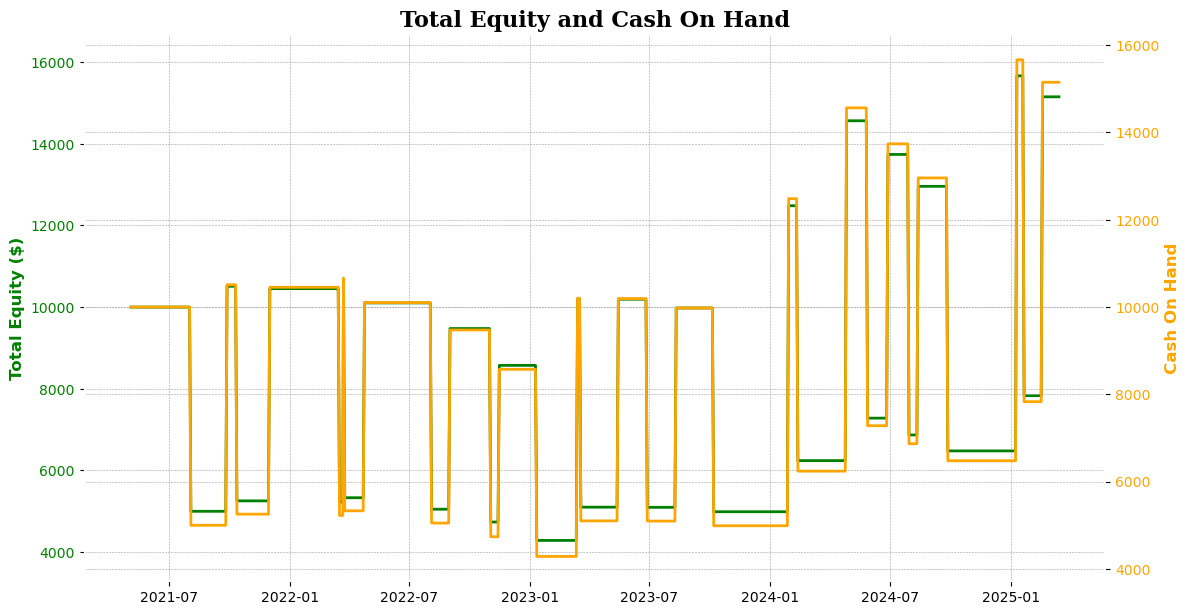

/Users/chrisgao/miniconda3/envs/crypto/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


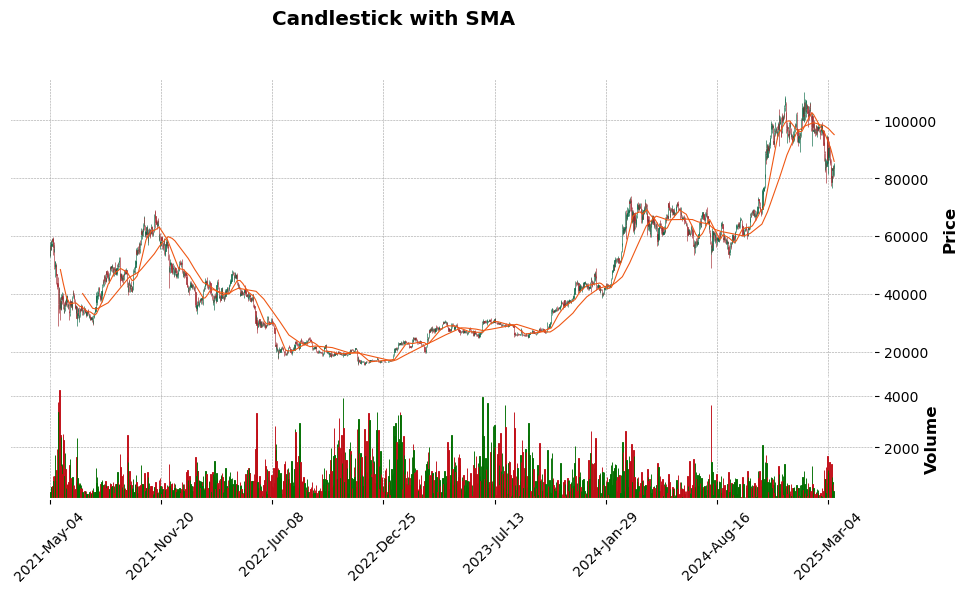

In [22]:
plot_chart(df)

In [ ]:

def sma(price, n):
  return price.rolling(n).mean()
def wma(price, n):
  return price.ewm(com=n).mean()

def highpass(Data, n=48):
  a	= (0.707*2*math.pi) / n

  alpha1 = (math.cos(a)+math.sin(a)-1)/math.cos(a);
  b	= 1-alpha1/2
  c	= 1-alpha1

  ret = [0] * len(Data)
  for i in range(2, len(Data)):
    ret[i] = b*b*(Data.iloc[i]-2*Data[i-1]+Data.iloc[i-2])+2*c*ret[i-1]-c*c*ret[i-2]

  return pd.Series(ret, index=Data.index)

def lowpass(Data,n):
  a = 2.0/(1+n)

  lp = [Data[0], Data[1]] + [0] * (len(Data) - 2)
  for i in range(2, len(Data)):
    lp[i] = (a-0.25*a*a)*Data[i]+ 0.5*a*a*Data[i-1]\
      - (a-0.75*a*a)*Data[i-2]\
      + 2*(1.-a)*lp[i-1]\
      - (1.-a)*(1.-a)*lp[i-2]

  return pd.Series(lp, index=Data.index)

def hullma(price, n):
  wma1 = wma(price, n//2)
  wma2 = wma(price, n)
  return wma(wma1 * 2 - wma2, int(math.sqrt(n)))

def zlma(price, n):
  """
  John Ehlers' Zero lag (exponential) moving average
  https://en.wikipedia.org/wiki/Zero_lag_exponential_moving_average
  """
  lag = (n - 1) // 2
  series = 2 * price - price.shift(lag)
  return wma(series, n)


def detrend(price, n):
  return price - highpass(price, n)


def alma(price, n):
  h = sg.windows.gaussian(n, n * 0.2)
  fil = sg.convolve(price, h / h.sum())
  filtered = pd.Series(fil[:len(price)], index=price.index)
  return filtered

In [ ]:
df['HMA'] = hullma(df['close'], 20)  
df['ZLMA'] = zlma(df['close'], 20)  
df['DPO'] = detrend(df['close'], 20)  

df['Signal'] = np.where((df['SMA_20'] > df['SMA_60']) & (df['ZLMA'] > df['DPO']), 1, 0)
df['Signal'] = np.where((df['SMA_20'] < df['SMA_60']) & (df['DPO'] < 0), -1, df['Signal'])

df['ATR'] = df['high'] - df['low']  
stop_loss = df['close'] - df['ATR'] * 1.5  # 1.5x ATR Stop Loss  
take_profit = df['close'] + df['ATR'] * 3  # 3x ATR Take Profit  

df['ALMA'] = alma(df['close'], 20)  
df['Highpass'] = highpass(df['close'], 48)  

df['Confirmed Buy'] = (df['Signal'] == 1) & (df['ALMA'] > df['Highpass'])  
df['Confirmed Sell'] = (df['Signal'] == -1) & (df['ALMA'] < df['Highpass'])

df['Position Size'] = np.maximum(100 / df['ATR'], 1)

